In [2]:
%matplotlib inline
import os, sys
from collections import OrderedDict
import numpy as np

import matplotlib.pyplot as plt

import torch
print(torch.__version__)

from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:90% !important; }</style>"))

sys.path.append('..')
import datasource, trainutils, pytorchutils, pytorchnet

plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation']='none'

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

0.4.1


['trainImg', 'trainCat', 'testImg', 'testCat', 'readme']
(60000, 28, 28) (60000,) (10000, 28, 28)


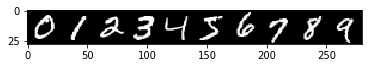

In [3]:
dat=np.load('mnist.npz')
print(list(dat.keys()))

rescale=lambda i:i.astype(np.float32)/256
trainImg=rescale(dat['trainImg'])
testImg=rescale(dat['testImg'])
trainCat=dat['trainCat']
dim=trainImg.shape[1]

print(trainImg.shape,trainCat.shape,testImg.shape)
firstDigits=[np.argwhere(trainCat==i)[0,0] for i in range(10)]
plt.imshow(np.hstack(trainImg[firstDigits]))

In [10]:
from importlib import reload 
pytorchnet=reload(pytorchnet)

class VAEMgrNB(pytorchutils.VarAutoEncoderMgr,trainutils.JupyterThreadMonitor):
    def __init__(self,net,src,batchSize,trainSteps):
        
        trainutils.JupyterThreadMonitor.__init__(self)
        pytorchutils.VarAutoEncoderMgr.__init__(self,net)
        self.src=src
        self.batchSize=batchSize
        self.trainSteps=trainSteps
        
    def run(self):
        with self.src.threadBatchGen(self.batchSize) as gen:
            self.train(gen,self.trainSteps)
        
    def evalStep(self,index,steploss,results):
        results+=self.toNumpy(self.netoutputs[0]).tolist()
            
    def updateStep(self,step,steploss):
        self.step=step
        self.updateGraphVals({'loss':steploss},('loss',))

        if step==1 or step%20==0:
            images=self.traininputs[0]
            recon=self.netoutputs[0]

            imgs={
                'image':self.toNumpy(images[0,0]),
                'recon':self.toNumpy(recon[0,0])
            }
            self.updateImageVals(imgs)

            
trainSteps=5000
batchSize=200
channels=(16,32,64)
strides=( 1, 2, 2)
latentSize=2

net=pytorchnet.VarAutoEncoder((dim,dim,1),1,latentSize,channels,strides)
src=datasource.DataSource(trainImg[:,np.newaxis],trainImg[:,np.newaxis])

mgr=VAEMgrNB(net,src,batchSize,trainSteps)
mgr.start()

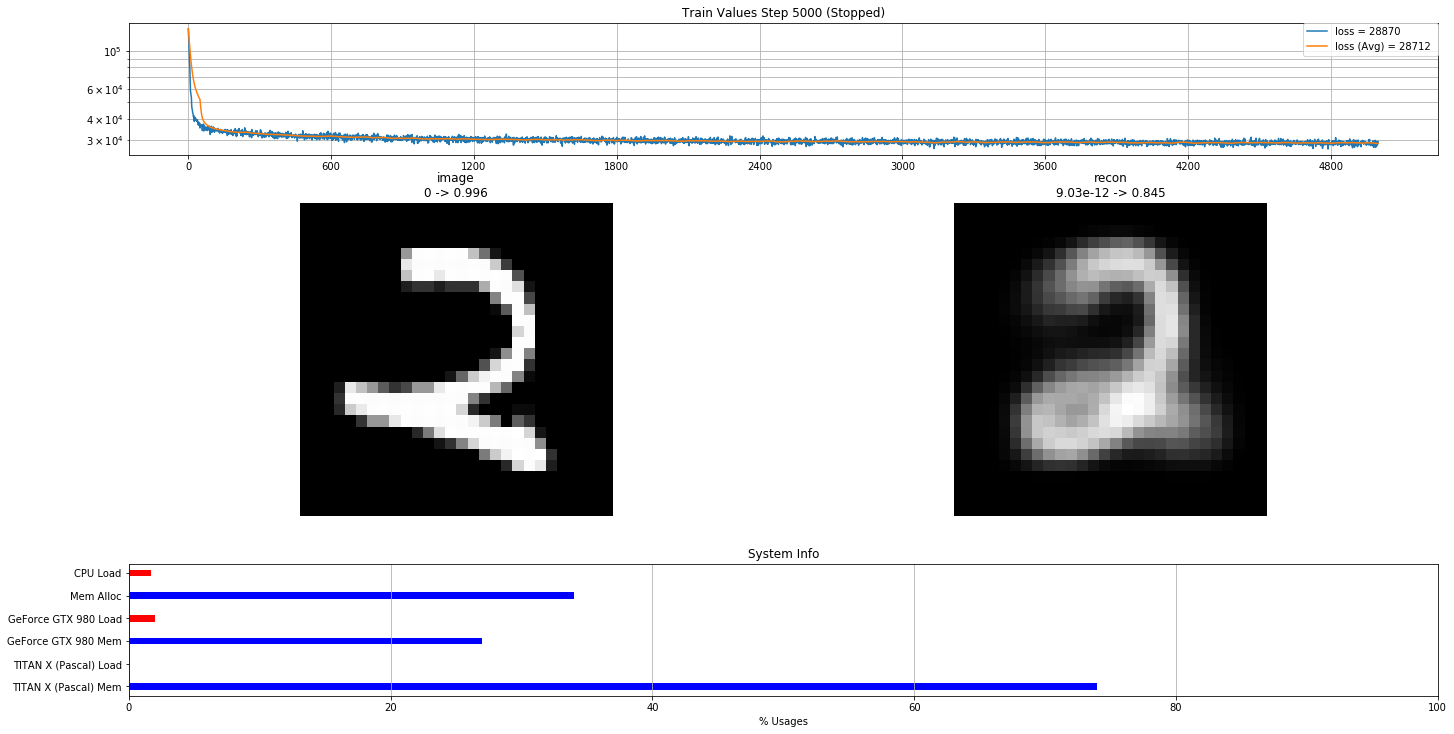

In [11]:
print(mgr.status())
mgr.displayMonitor()

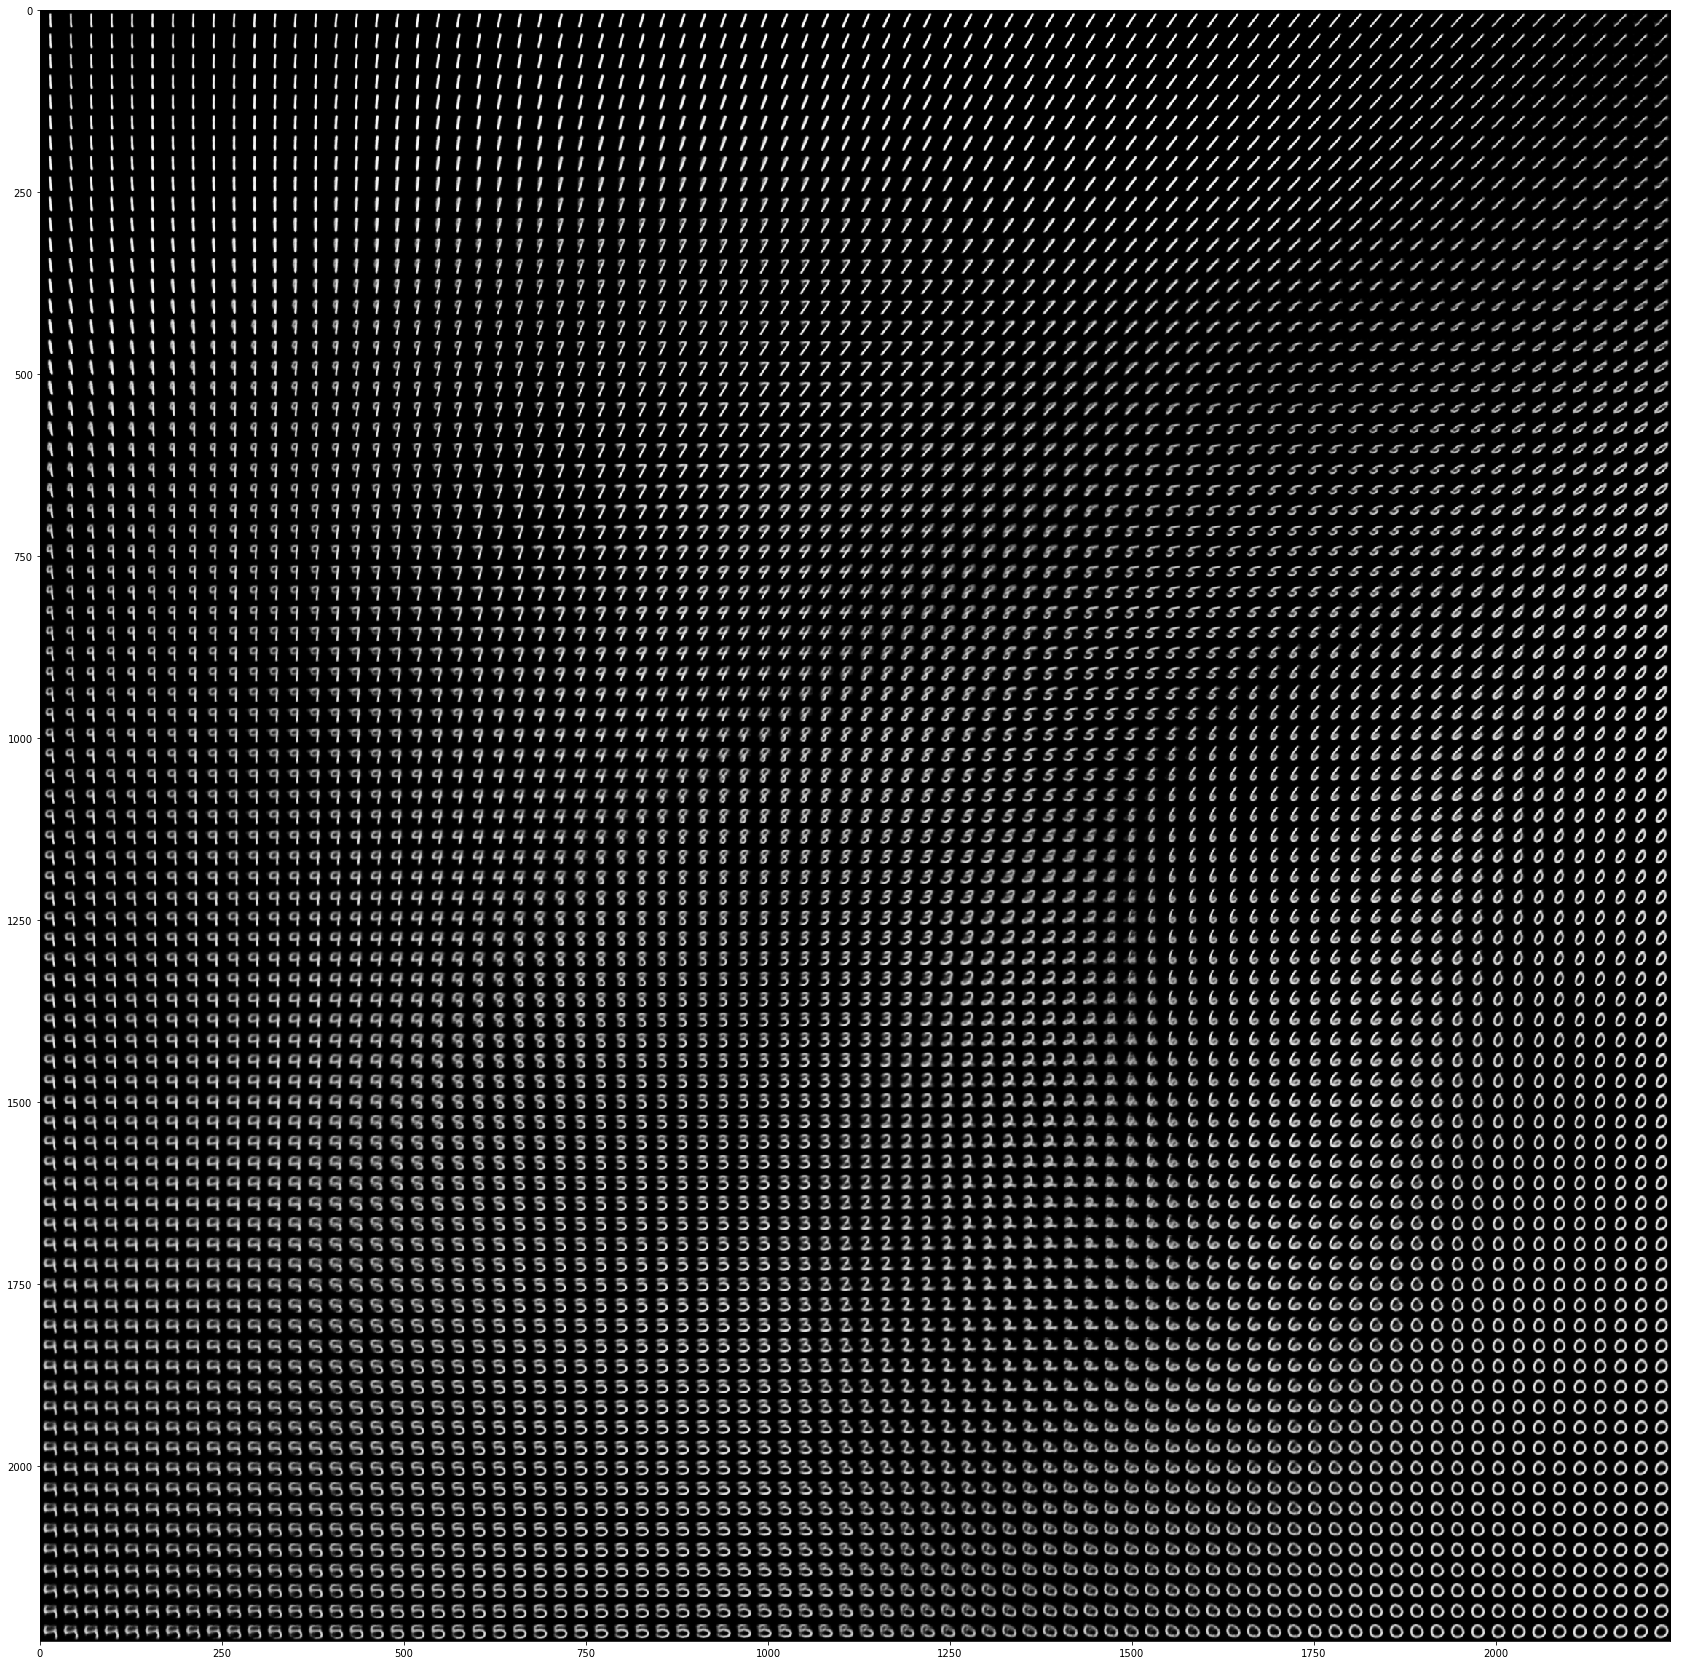

In [12]:
w,h=80,80
dist=2.5
out=[list() for _ in range(h)]

net.eval()

with torch.no_grad():
    for y,j in enumerate(np.linspace(-dist,dist,h)):
        for x,i in enumerate(np.linspace(-dist,dist,w)):
            sample=torch.tensor([[i,j]]).cuda()
            o=mgr.toNumpy(net.decode(sample)).reshape((-1,dim,dim))[0]
            out[y].append(o)
    
fig=plt.figure(figsize=(30,30))
plt.imshow(np.block(out))